In [1]:
import numpy as np
import networkx as nx
import os
import itertools  # for product
import math
import matplotlib.pyplot as plt
import random
from collections import Counter
import time
import seaborn as sns
from pathlib import Path
import glob


In [2]:
from numba import jit, njit

In [3]:
os.chdir(r"F:\Portfolio\TSP")
# from utils import draw_graph

In [4]:
os.getcwd()

'F:\\Portfolio\\TSP'

In [5]:
global sol_file, input_filename

def prepare_paths(instance_name):
    global sol_file, input_filename
    folder = Path(r"data")
    filename = Path(instance_name + ".tsp")
    input_filename = folder.joinpath(filename)
    sol_filename = filename.stem + ".opt.tour"
    sol_folder = folder.joinpath(r"solution")
    sol_file = Path.cwd().joinpath(sol_folder, sol_filename)

In [6]:
def read_opt_sol(sol_file):
    if sol_file.is_file():
        sol_txt = sol_file.read_text()
        sol_lines = sol_txt.split()
        sol_lines
        idx = 0
        line = sol_lines[idx]

        while not line.startswith("TOUR_SECTION"):
            idx += 1
            line = sol_lines[idx]

        idx += 1

        remaining_line = [x.strip() for x in sol_lines[idx:] if x]
        #print(remaining_line)
        opt_sol = []
        while not sol_lines[idx].startswith("-1"):
            line = sol_lines[idx]
            opt_sol.append(int(line))
            idx += 1

        opt_sol.append(opt_sol[0])
        #print(opt_sol)
        return opt_sol
    else:
        return []


In [7]:
def parse_tsplib_file(input_filename):
    with open(input_filename) as file:
        lines = file.read().splitlines()
        lines = [line.strip() for line in lines if line]
        assert lines[-1] == 'EOF'
        lines = lines[0:len(lines)-1] # cut off EOF line

        idx = 0
        line = lines[idx]
        print(line)
        while not line.startswith("DIM"):
            idx += 1
            line = lines[idx]

        num_city = int(lines[idx].split(": ")[1])
        #print(f"Number of cities : {num_city}")
        #print("Number of cities : ", num_city)

        while not line.startswith("NODE_COORD_SECTION"):
            idx += 1
            line = lines[idx]

        idx += 1
        pos_dict = {}
        for i in range(idx, len(lines)):
            line = lines[idx]
            line_arr = line.split(" ")
            city, x_coord, y_coord = int(line_arr[0]), float(line_arr[1]), float(line_arr[2])
            pos_dict[city] = (x_coord, y_coord)
            idx += 1

        assert len(pos_dict) == num_city
        #print(pos_dict)
        return pos_dict

In [8]:
def compute_distances(pos_dict):
    nodes = pos_dict.keys()
    dist_dict = {}
    for node1, node2 in itertools.product(nodes, nodes):
        (x1, y1), (x2, y2) = pos_dict[node1], pos_dict[node2]
        dist = math.sqrt( 
                    (x2 - x1)**2 + (y2 - y1)**2 
        )
        dist_dict[(node1, node2)] = dist
    return dist_dict

In [9]:
t1 = time.time()

In [10]:
# build a complete graph
def build_input_graph(pos_dict, distances):
    G = nx.Graph()
    for node in pos_dict.keys():
        G.add_node(node)
    for node_pair in itertools.product(pos_dict.keys(), pos_dict.keys()):
        node1, node2 = node_pair[0], node_pair[1]
        if node1 != node2:
            G.add_edge(node1, node2)
            G.edges[node_pair]['distance'] = distances[node_pair]
    print("Base Graph built.")
    return G


In [11]:
def invert_weights(G, weight_str):
    for edge in G.edges:
        G.edges[edge][weight_str] = 0 - G.edges[edge][weight_str]
        
    new_sign_is_positive =  G.edges[edge][weight_str]  > 0
    
    #if new_sign_is_positive:
    #    new_sign = "+ve"
    #    old_sign = "-ve"
    #else:
    #    new_sign = "-ve"
    #    old_sign = "+ve"
    #print (f"Weights sign changed to {old_sign} to {new_sign}")
    
def min_weight_matching(G, weight='distance'):
    invert_weights(G, "distance")
    min_match_G = nx.max_weight_matching(G, maxcardinality=True, weight=weight)
    invert_weights(G, "distance")
    return min_match_G    

def find_shortest_path_candidate(H, current_vertex, target, is_global_unvisited):
    #print("choosing random")
    if not is_global_unvisited:   # if all global nodes are visited
        #print("Global is visited.")
        candidates = list(H.neighbors(current_vertex))
    else:
        candidates = list(set(list(H.neighbors(current_vertex))) - set([target]))
        #print("candidates", candidates)
    return random.choice(candidates)
"""    current_best_length = math.inf
    current_best_node = None
    for v in candidates:
        length = nx.shortest_path_length(G, source=v, target=target, weight='distance', method='dijkstra')
        #print("shortest_path:", v, length)
        if length < current_best_length:
            current_best_length = length
            current_best_node = v"""
    #return current_best_node

def find_euler_tour_mine_not_working(H):
    print("Begin Euler Tour.")
    node_list = list(H.nodes)
    tour_start = random.choice(node_list)
    
    visited = set()
    visited.add(tour_start)
    all_s = set(H.nodes)
    current_vertex = tour_start 
    insertion = [tour_start]
    while len(visited) < len(H.nodes):
        unvisited = set(H.neighbors(current_vertex)) - visited
        #print("current vertex: ", current_vertex, ";  ", "unvisited: ", unvisited)
        #print("global unvisited: ", all_s - visited)
        if len(unvisited) > 0:
            who = random.choice(list(unvisited))
            visited.add(who)
            insertion.append(who)
            #print(f"Added {who}")
            current_vertex = who
        else:
            is_global_unvisited = len(all_s - visited) > 0
            who = find_shortest_path_candidate(H, current_vertex, target=tour_start, is_global_unvisited=is_global_unvisited)
            visited.add(who)
            insertion.append(who)
            current_vertex = who
            #print(f"Added {who}")
    insertion.append(tour_start)
    #print(insertion)
    #len(insertion)
    print("End Euler Tour.")
    return insertion    

In [12]:
def find_euler_path(H, V):
    # procedure FindEulerPath(V)
    #    1. iterate through all the edges outgoing from vertex V;
    #          remove this edge from the graph,
    #          and call FindEulerPath from the second end of this edge;
    #    2. add vertex V to the answer.
    return nx.eulerian_circuit(G, source=V)

In [13]:
def cut_short_tour(ss):
    # these vertices occur more than once in the path
    # (vertex, n times)
    # to remove them n-1 times
    tour_start = ss[-1]
    cutting_list = [(key, val) for key, val in Counter(ss).items() if val > 1 and key != tour_start]
    #print(cutting_list)
    for node, frequency in cutting_list:
        for _ in range(frequency-1):
            ss.remove(node)
    #print(ss)
    assert(len(ss) == len(G)+1), "Not a tour."

    # create edges from vertices in the path
    v_path = ss[:-1]
    path = []
    for i in range(len(v_path)):
        path.append((ss[i], ss[i+1]))

    tour = nx.Graph()
    tour.add_edges_from(path)
    for edge in tour.edges:
        tour.edges[edge]['distance'] = G.edges[edge]['distance']

    cost = tour.size(weight='distance')
    # print("Tour cut short.")
    return cost

In [14]:
def approx_tsp(G, tour_start=1):
    # Step 1 Minimum weight spanning tree T
    mst = nx.minimum_spanning_tree(G, weight='distance')
    # mst.size(weight='distance')

    # Step 2 Minimum matching M for the odd-degree vertices in T
    degrees = dict(mst.degree)
    O = [key for key, val in degrees.items() if val % 2 != 0]
    G_sub = G.subgraph(O).copy()
    min_matching_set = min_weight_matching(G_sub)
    #min_matching_set
    assert nx.is_perfect_matching(G_sub, min_matching_set)

    # Step 3 Add M to T
    # combine edges from mst and min_matching_set
    H = nx.MultiGraph(mst, weight='distance')
    for edge in min_matching_set:
        H.add_edge(edge[0], edge[1])
    
    odd_v = [(key, val) for key, val in H.degree if val % 2 != 0]
    assert len(odd_v) == 0
    # print(nx.is_eulerian(H))
    
    # Step 4 Find an Euler tour
    #insertion = list(find_euler_path(H, 1))
    tour_start = random.choice(list(H.nodes))
    euler_circuit = nx.eulerian_circuit(H, tour_start)
    inserted = set()
    insertion = []
    for edge in euler_circuit:
        if not edge[0] in inserted:
            insertion.append(edge[0])
            inserted.add(edge[0])
        if not edge[1] in inserted:
            insertion.append(edge[1])
            inserted.add(edge[1])      
    
    insertion.append(tour_start)
    # print(insertion)
    
    ss = insertion.copy()

    # Step 5 Cut short Euler tour
    cost = cut_short_tour(ss)
    #print(f"Cost of tour = {cost}")
   
    # assert approx_ratio > 1
    #print(approx_ratio)
    return cost

In [15]:
instance_name = "kroA200"
prepare_paths(instance_name)
print(input_filename)
pos_dict = parse_tsplib_file(input_filename)
distances = compute_distances(pos_dict)
G = build_input_graph(pos_dict, distances)
#nx.get_edge_attributes(G, 'distance')


data\kroA200.tsp
NAME: kroA200
Base Graph built.


Optimal Solution not found.
100 iterations.
Cost:		 min=33239.19799293647		 max = 33984.03335911517;	 mean = 33657.9669488523
Approx ratio:	 min=-0.0		 max = -0.0;	 mean = -0.0
100 Iterations took 91.47456383705139 seconds.


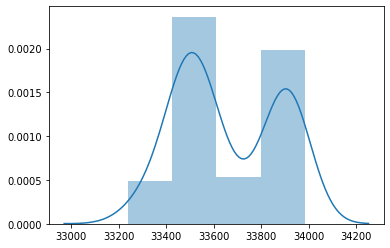

In [18]:
num_iter = 100
cost_arr = np.empty(num_iter)
time_arr = np.empty(num_iter)
start = time.time()
for i in range(num_iter):
    t2 = time.time()
    cost_arr[i] = approx_tsp(G)
    time_arr[i] = time.time()-t2 
min_cost = min(cost_arr)
max_cost = max(cost_arr)
mean_cost = np.mean(cost_arr)

min_time = min(time_arr)
max_time = max(time_arr)
mean_time = np.mean(time_arr)

end = time.time()
opt_sol = read_opt_sol(sol_file)
if len(opt_sol) > 0:
    opt_cost = cut_short_tour(opt_sol)
    print(f"Optimal solution from file: {opt_cost}\n")
else:
    opt_cost = -math.inf
    print("Optimal Solution not found.")

print(f"{num_iter} iterations.")
print(f"Cost:\t\t min={min_cost}\t\t max = {max_cost};\t mean = {mean_cost}")
print(f"Approx ratio:\t min={min_cost/opt_cost}\t\t max = {max_cost/opt_cost};\t mean = {mean_cost/opt_cost}")
#print(f"Time:     min={min_time}\t max = {max_time};\t mean = {mean_time}\n")

print(f"{num_iter} Iterations took {end-start} seconds.")

sns.set_style()
ax = sns.distplot(cost_arr)
plt.show()
#print(sns.distplot(time_arr))

In [17]:
t3 = time.time()
print(f"Program took {t3 - t1} seconds.")

Program took 5.436467170715332 seconds.


In [19]:
V_len = len(G.nodes)
d = np.empty((V_len, V_len), dtype=float)
for i in range(V_len):
    for j in range(V_len):
        d[i,j] = distances[(i+1, j+1)]

In [3]:

def shuffler(d, permutation = list(range(200)):
    counter = 0
    best_cost = math.inf
    for i in range(int(1e4)):
        counter += 1
        np.random.shuffle(permutation)
        cost = d[(permutation[0], permutation[-1])]
        for x in range(200-1):
            cost += d[(permutation[x], permutation[x+1])]
        if cost < best_cost:
            best_cost = cost
    return counter    

SyntaxError: invalid syntax (<ipython-input-3-52d8a813b045>, line 1)

In [ ]:
#import tsp

In [ ]:
#t = tsp.tsp(list(pos_dict.values()))
#print(t)

In [ ]:
ss2 = list(np.add([0, 15, 11, 12, 13, 5, 6, 9, 8, 10, 4, 14, 7, 3, 1, 2], 1))
ss2.append(1)
ss2

In [ ]:
74.82608415730981/73.98761804517501